# Attack Classifier

This project will apply machine learning classification to the problem of attributing terrorist attacks to perpetrators. The Global Terrorism Database (GTD) contains many events that lack a definitive attribution. Machine learning should be able to use attack attributes to predict with varying degrees of confidence which group perpetrated these unattributed attacks. The ACLED database has many fewer unattributed events, and thus should provide a reasonable amount of validation.

In [13]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
gtd = pd.read_csv('../data/globalterrorismdb_0919dist.csv.zip')

/Users/david/gtd_classifier/gtd_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,32,34,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
gtd.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
gtd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191464 entries, 0 to 191463
Columns: 136 entries, Unnamed: 0 to related
dtypes: float64(53), int64(25), object(58)
memory usage: 198.7+ MB


In [5]:
gtd['iyear'].max()

2018

In [6]:
gtd['country_txt'].value_counts()

Iraq                   26057
Pakistan               14847
Afghanistan            14509
India                  12853
Colombia                8515
                       ...  
International              1
St. Lucia                  1
Vatican City               1
Antigua and Barbuda        1
Wallis and Futuna          1
Name: country_txt, Length: 205, dtype: int64

In [7]:
gtd[gtd['country_txt'] == 'Iraq']['gname'].value_counts()

Unknown                                        19233
Islamic State of Iraq and the Levant (ISIL)     5486
Al-Qaida in Iraq                                 632
Islamic State of Iraq (ISI)                      145
Asa'ib Ahl al-Haqq                                71
                                               ...  
Islamic Movement of Iraqi Mujahidin                1
Iraqi Sunni Extremists                             1
Unified Kurdish Socialist Party                    1
Liberals of Galilee                                1
Hizballah-Iraq                                     1
Name: gname, Length: 102, dtype: int64

In [8]:
gtd[gtd['country_txt'] == 'Afghanistan']['gname'].nunique()

45

In [9]:
gtd[gtd['country_txt'] == 'Afghanistan']['gname'].value_counts()

Taliban                                                                                 8671
Unknown                                                                                 5220
Khorasan Chapter of the Islamic State                                                    357
Haqqani Network                                                                           85
Hizb-I-Islami                                                                             42
Al-Qaida                                                                                  20
Tehrik-i-Taliban Pakistan (TTP)                                                           15
Gunmen                                                                                     9
Afghan Guerrillas                                                                          7
Afghan Mujahideen                                                                          7
Guerrillas                                                            

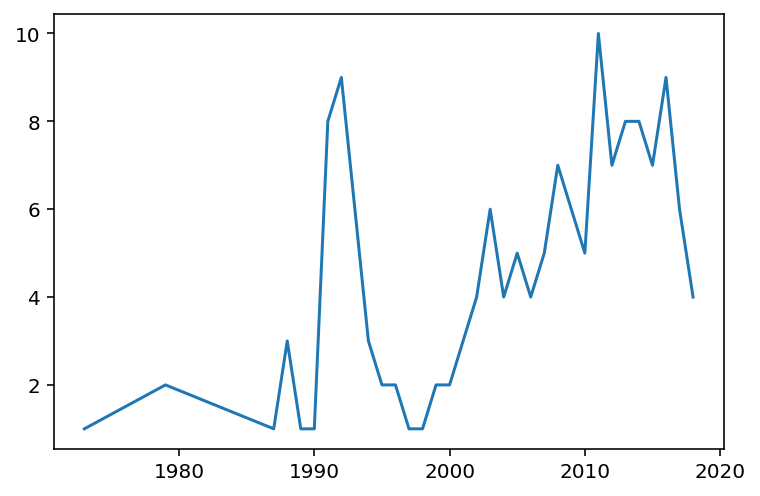

In [10]:
afg_yearly = gtd[gtd['country_txt'] == 'Afghanistan'].groupby('iyear')['gname'].agg('nunique')

plt.plot(afg_yearly)

Afghanistan seems like a suitable choice. There is a large number of events for training the model. The number of classes is more manageable than many countries with lots of attacks.

# Afghanistan

## Feature Engineering and Selection

In [62]:
afg = gtd[gtd['country_txt'] == 'Afghanistan']

In [46]:
afg.shape

(14509, 136)

### Dates

We'll use the day of the week, month (as a category) as year (as numeric). The latter two are good to go, but the day requires some work. First, the day is listed as zero if it is not known precisely. We'll create a binary flag indicating this and then set the day to the rounded mean of 15.

In [63]:
# pandas throws a warning recommending I use a copy here - seems like false positive, but better safe than sorry
af2 = afg.copy()
af2['day_imprecise'] = af2['iday'].apply(lambda x: 1 if x==0 else 0)
afg = af2.copy()

In [48]:
afg['day_imprecise'].value_counts()

0    14496
1       13
Name: day_imprecise, dtype: int64

In [64]:
afg['day_recode'] = afg['iday'].replace(0, 15)

In [65]:
# create full date column
afg['full_date'] = afg['imonth'].astype(str) + "-" + afg['day_recode'].astype(str) + "-" + afg['iyear'].astype(str)
afg['full_date'] = pd.to_datetime(afg['full_date'])

In [66]:
# extract day of week
afg['day_of_week'] = afg['full_date'].dt.dayofweek

### Incident Info

The criteria variables have minimal useful variation. The 'doubtterr' variable is potentially useful, we just need to recode -9 (data collected before this variable existed). We'll se them to 0

In [67]:
afg['doubtterr'] = afg['doubtterr'].replace(-9, 0)

In [56]:
afg['multiple'].value_counts()

0    12422
1     2087
Name: multiple, dtype: int64

Part of multiple indicator seems worth including.

### Location

There are several useful location items that can be included without modification. I will include province, but city has too many values.

In [57]:
afg['provstate'].value_counts()

Helmand             1325
Kandahar            1218
Nangarhar           1105
Kabul                983
Ghazni               928
Herat                720
Faryab               662
Farah                638
Kunduz               578
Uruzgan              513
Khost                480
Kunar                480
Zabul                435
Baghlan              388
Logar                385
Jawzjan              350
Paktika              347
Wardak               325
Paktia               299
Badghis              247
Laghman              246
Badakhshan           209
Takhar               208
Parwan               208
Balkh                202
Ghor                 195
Nimroz               181
Sari Pul             180
Kapisa               159
Nuristan              99
Unknown               95
Samangan              67
Bamyan                30
Daykundi              20
Panjsher               3
Paktika Province       1
Name: provstate, dtype: int64

In [59]:
afg['vicinity'].value_counts()

0    13800
1      709
Name: vicinity, dtype: int64

In [60]:
afg['city'].value_counts()

Unknown                   1202
Kabul                      847
Kandahar                   390
Jalalabad                  304
Ghazni                     215
                          ... 
Kaj Qala                     1
Khak Yarak                   1
Almalak                      1
Jahangir                     1
Shah Wali Kot District       1
Name: city, Length: 3149, dtype: int64

### Attack/Weapon Info

9 is uknown, but since this will be handled with one-hot encoding, it doesn't require any special treatment at this stage.

In [61]:
afg['attacktype1'].value_counts( )

3    6784
2    3264
9    1671
6    1185
1    1067
7     397
8      78
5      42
4      21
Name: attacktype1, dtype: int64

In [65]:
afg['attacktype2'].isna().sum() / afg.shape[0]

0.9494107105934247

94% of attacktype2 is missing, so we'll exclude that.

In [76]:
afg['weaptype1'].value_counts()

6     7403
5     4295
13    2237
8      351
9      147
2       61
11       6
12       6
10       3
Name: weaptype1, dtype: int64

13 is unknown, but again one hot will effectively flag this.

In [78]:
afg['weaptype2'].isna().sum() / afg.shape[0]

0.9351437039079192

Again, mostly missing so we'll ignore it.

### Victim & Perpetrator Info

In [101]:
afg['targtype1'].value_counts()

3     4152
14    2921
4     2625
2     1835
20     860
1      506
8      356
15     255
17     184
19     165
12     163
7      156
10      89
16      79
6       64
21      45
22      27
9       14
13       8
18       4
11       1
Name: targtype1, dtype: int64

13 is other. Let's fold the two smaller categories (18=tourists, 11=maritime) into that category.

In [69]:
afg['targtype1'] = afg['targtype1'].replace({18: 13, 11: 13})

In [71]:
afg['natlty1'].value_counts()

4.0      12429
422.0      903
217.0       88
153.0       37
999.0       37
92.0        29
209.0       18
75.0        14
69.0        12
216.0       12
98.0        11
94.0        10
95.0         9
38.0         7
184.0        6
19.0         6
101.0        5
44.0         4
142.0        3
334.0        3
14.0         3
6.0          2
199.0        2
198.0        2
214.0        2
202.0        2
167.0        2
151.0        1
185.0        1
91.0         1
55.0         1
141.0        1
173.0        1
74.0         1
215.0        1
205.0        1
97.0         1
347.0        1
210.0        1
359.0        1
Name: natlty1, dtype: int64

4 = Afg, 422 = International, 217 = US, 153 = Pak, 999 = Multinational, 92 = India, 209 = Turkey

Let's keep top 5 and recode rest to 'other'. International vs. Multinational might be picking up on something useful.

In [77]:
afg['natlty1'] = afg['natlty1'].map({4: 'Afg', 422.0: 'Int', 217: 'USA', 153: 'Pak', 999: 'Multi'}).fillna('Other').value_counts()

In [82]:
afg['gname2'].notnull().sum()

165

Cases of second attacking groups are rare, but this could be informative. Let's construct a binary indicator from this.

In [92]:
afg['multiple_attackers'] = afg['gname2'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [93]:
afg['guncertain1'].value_counts()

0.0    13354
1.0     1155
Name: guncertain1, dtype: int64

In [95]:
afg['nperps'].describe()

count    13525.000000
mean       -76.924362
std         65.187849
min        -99.000000
25%        -99.000000
50%        -99.000000
75%        -99.000000
max       2000.000000
Name: nperps, dtype: float64

-99 is the missing value code so let's fix that

In [99]:
afg['nperps'] = afg['nperps'].replace(-99, np.NaN)

afg['nperps'].describe()

count    2466.000000
mean       22.075831
std       106.408934
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      2000.000000
Name: nperps, dtype: float64

nperpcap will probably be too collinear to include.

In [100]:
afg['claimed'].value_counts()

 0.0    9842
 1.0    4453
-9.0     100
Name: claimed, dtype: int64

Claims of responsibility are only coded for 1997-present, but seem very useful.

In [103]:
afg['claimed'] = afg['claimed'].replace(-9, np.NaN)

### Outcomes

In [105]:
afg['nkill'].describe()

count    14013.000000
mean         3.511168
std          8.807718
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        466.000000
Name: nkill, dtype: float64

In [106]:
afg['nkill'].isna().sum()

496

In [108]:
afg['nkillus'].describe()

count    14339.000000
mean         0.035149
std          0.310270
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: nkillus, dtype: float64

In [109]:
afg['nkillus'].isna().sum()

170

In [110]:
afg['nkillter'].describe()

count    13899.000000
mean         1.444061
std          6.209684
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        326.000000
Name: nkillter, dtype: float64

In [111]:
afg['nkillter'].isna().sum()

610

In [113]:
afg['nwound'].describe()

count    13536.000000
mean         3.850547
std         12.584563
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        491.000000
Name: nwound, dtype: float64

In [114]:
afg['nwound'].isna().sum()

973

In [118]:
afg['nwoundus'].describe()

count    14288.000000
mean         0.034155
std          1.118741
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        101.000000
Name: nwoundus, dtype: float64

In [119]:
afg['nwoundus'].isna().sum()

221

In [120]:
afg['nwoundte'].describe()

count    13514.000000
mean         0.685733
std          3.331466
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: nwoundte, dtype: float64

In [121]:
afg['nwoundte'].isna().sum()

995

In [122]:
afg['property'].value_counts()

 0    6730
 1    5038
-9    2741
Name: property, dtype: int64

In [123]:
afg['propextent'].value_counts()

3.0    3839
4.0    1415
2.0      20
Name: propextent, dtype: int64

The binary property damage is worth trying. For extent, 4 is unknown, so we don't really have much differentiation at all from that predictor.

In [125]:
afg['property'] = afg['property'].replace(-9, np.NaN)

In [126]:
afg['ishostkid'].value_counts()

 0.0    13106
 1.0     1308
-9.0       95
Name: ishostkid, dtype: int64

Kidnappings are rare in Afg, but there are enough to be of potential use.

In [128]:
afg['ishostkid'] = afg['ishostkid'].replace(-9, np.NaN)

### Feature Lists

In [131]:
cat_predictors = [
    'day_imprecise',
    'day_of_week',
    'imonth',
    'extended',
    'doubtterr',
    'multiple',
    'provstate',
    'vicinity',
    'attacktype1',
    'success',
    'suicide',
    'weaptype1',
    'targtype1',
    'natlty1',
    'multiple_attackers',
    'guncertain1',
    'nperps',
    'claimed',
    'property',
    'ishostkid'
]

cont_predictors = [
    'iyear',
    'latitude',
    'longitude',
    'specificity',
    'nkill',
    'nkillus',
    'nkillter',
    'nwound',
    'nwoundus',
    'nwoundte'
]

In [132]:
print(len(cat_predictors))
print(len(cont_predictors))

20
10


Descriptions of the features:

Name | Type | Values | Desc | How Created
-|-|-|-|-
day_imprecise | cat | [0,1] | whether exact day is unknown | if iday == 0
day_of_week | cat | [0:6] | day of week | pandas dt.dayofweek w/ imprecise dates set to 15th (mean)
imonth | cat | [1:12] | month | included
iyear | int | [1970:2018] | year, treated as continuous | included
extended | cat | [0,1] | whether event lasted > 24 hrs | included
doubtterr | cat | [0,1] | whether coders doubt attack meets definition of terrorism | included, but -9 (obs predates variable) recoded to 0
multiple | cat | [0,1] | whether attack connected to other incidents | included
provstate | cat | string | name of province | included
vicinity | cat | [0,1] | 0=event occurred in city, 1=event occurred in vicinity | included
latitude | num | | | included
longitude | num | | | included
specificity | cat | [1,5] | lower=more precise geocoding. treated as continuous | included
attacktype1 | cat | [1,9] | type of attack - see codebook | included
success | cat | [0,1] | 0=unsuccessful, 1=successful | included
suicide | cat | [0,1] | 0=not suicide, 1=suicide | included
weaptype1 | cat [1,13] | type of weapon - see codebook | included
targtype1 | cat | many | type of target - see codebook | included, but combined 3 smallest categories
natlty1 | cat | string | nationality of victim | included, but recoded to top 5 + 'other'
multiple_attackers | cat | [0,1] | 1=multiple attacking groups named, 0=only 1 named | constructed from gname2 column
guncertain1 | cat | [0,1] | 1=uncertainty about attribution, 0=certain | included
nperps | num | | number of perpetrators | included
claimed | cat | [0,1] | group claimed credit for attack | included
property | cat | [0,1] | 1=property damage, 0=no | included
nkill | num | | total fatalities | included
nkillus | num | | number of Americans killed | included
nkillter | num || number of perpetrators killed | included
nwound | num || total wounded | included
nwoundus | num || number of Americans wounded | included
nwoundte | num || number of perpetrators wounded | included
ishostkid | cat | [0,1] | 1=some/all victims kidnapped/taken hostage, 0=no | included

## Create Testing Set of Unattributed Attacks

First we'll extract the unknown and generic perpetrators to serve as a testing set.

In [133]:
# the Afghan Mujahideen are a boderline case - they seem to have had some amount of organization during the Soviet invasion
afg_generic = [
    'Unknown',
    'Gunmen',
    'Afghan Guerrillas',
    'Guerrillas',
    'Opposition Group',
    'Militants',
    'Insurgents',
    'Muslim extremists',
    'Muslim Militants',
    'Islamist extremists',
    'Muslim Guerrillas',
    'Anti-United States extremists',
    'Afghan Rebels',
    'Shia Muslim extremists'
]

afg_test = afg[afg['gname'].isin(afg_generic)]

afg_test.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,INT_IDEO,INT_MISC,INT_ANY,related,day_imprecise,day_recode,full_date,day_of_week,multiple_groups,multiple_attackers
7627,7627,197902140010,1979,2,14,NaN,0,NaN,4,Afghanistan,...,-9,1,1,NaN,0,14,1979-02-14,2,0,0
9156,9156,197908270005,1979,8,27,NaN,0,NaN,4,Afghanistan,...,-9,0,-9,NaN,0,27,1979-08-27,0,0,0
9218,9218,197909090001,1979,9,9,NaN,0,NaN,4,Afghanistan,...,-9,-9,-9,NaN,0,9,1979-09-09,6,0,0
33929,33929,198803270001,1988,3,27,NaN,0,NaN,4,Afghanistan,...,1,1,1,NaN,0,27,1988-03-27,6,0,0
34063,34063,198804100009,1988,4,10,NaN,0,NaN,4,Afghanistan,...,-9,0,-9,NaN,0,10,1988-04-10,6,0,0


In [134]:
afg_test.shape

(5269, 142)

<AxesSubplot:>

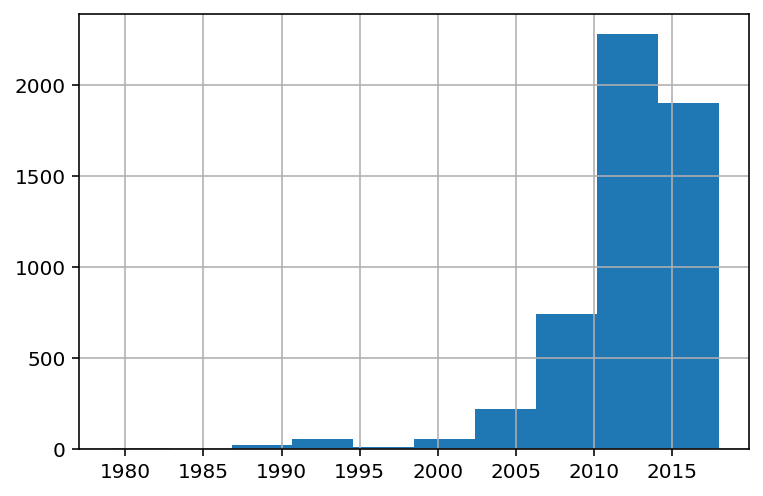

In [135]:
afg_test['iyear'].hist()

In [136]:
(afg_test['iyear'] > 2016).value_counts()

False    4473
True      796
Name: iyear, dtype: int64

There are 796 events that could potentially appear in ACLED, which covers Afghanistan for the period 2017-present. That seems like a reasonable sample size for external validation.

# Construct Training and Validation Sets

In [149]:
# extract Afg events that are not in the generic list
afg_X = afg[~(afg['gname'].isin(afg_generic))]

afg_X.shape

(9240, 142)

### Class Imbalance

We have a significant class imbalance problem:

In [138]:
afg_X['gname'].value_counts()

Taliban                                                                                 8671
Khorasan Chapter of the Islamic State                                                    357
Haqqani Network                                                                           85
Hizb-I-Islami                                                                             42
Al-Qaida                                                                                  20
Tehrik-i-Taliban Pakistan (TTP)                                                           15
Afghan Mujahideen                                                                          7
Mahaz Fedai Tahrik Islami Afghanistan                                                      5
The Northern Alliance (or United Islamic Front for Salvation of Afghanistan - UIFSA)       5
Hezb-e Wahdat-e Islami-yi Afghanistan                                                      5
Jamiat-e Islami-yi Afghanistan                                        

Let's start by simply combining the smallest categories

In [150]:
# another warning about chained selection
afx2 = afg_X.copy()
afx2['gsize'] = afx2.groupby('gname')['eventid'].transform(np.size)
afg_X = afx2.copy()

In [175]:
afg_X['gname_recode'] = np.where(afg_X['gsize'] < 5, 'Smaller_group', afg_X['gname'])

afg_X['gname_recode'].value_counts()

Taliban                                                                                 8671
Khorasan Chapter of the Islamic State                                                    357
Haqqani Network                                                                           85
Hizb-I-Islami                                                                             42
Smaller_group                                                                             28
Al-Qaida                                                                                  20
Tehrik-i-Taliban Pakistan (TTP)                                                           15
Afghan Mujahideen                                                                          7
Hezb-e Wahdat-e Islami-yi Afghanistan                                                      5
The Northern Alliance (or United Islamic Front for Salvation of Afghanistan - UIFSA)       5
Mahaz Fedai Tahrik Islami Afghanistan                                 

In [201]:
# shortern NA name
afg_X['gname_recode'] = afg_X['gname_recode'].replace('The Northern Alliance (or United Islamic Front for Salvation of Afghanistan - UIFSA)', 'Northern Alliance')

# Basic RF Model

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [202]:
keep_cols = cont_predictors + cat_predictors

X = afg_X[keep_cols].copy()

y = afg_X['gname_recode']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [203]:
# pipeline

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2, weights="uniform")),
    ('standardscaler', StandardScaler()) 
])


# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, cont_predictors),
        ('cat', categorical_transformer, cat_predictors)
    ])

#models
RF = RandomForestClassifier(n_estimators=100, random_state=0)

RF_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RF)
                     ])

RF_pipe.fit(X_train, y_train)

metrics.accuracy_score(RF_pipe.predict(X_test), y_test)

0.9675324675324676

96.8% prediction accuracy seems great at first glance, but this is not always a revealing metric for imbalanced classes. Let's look at the confusion matrix:

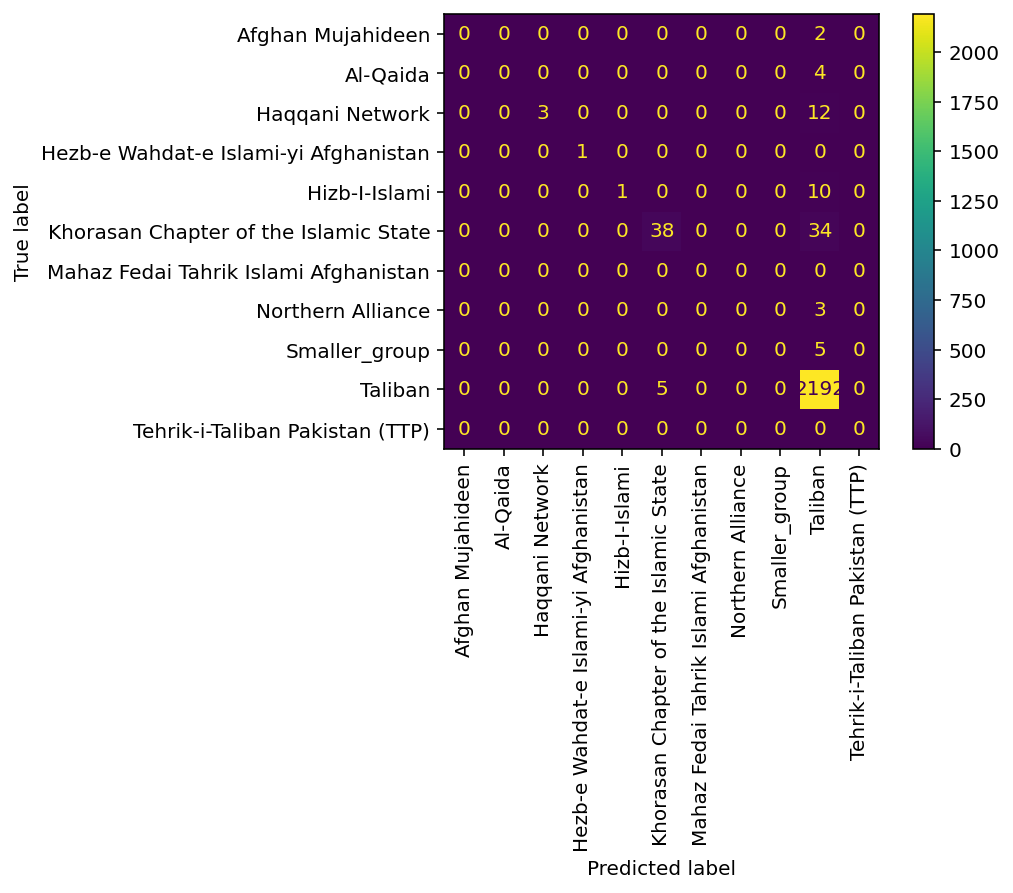

In [204]:
metrics.plot_confusion_matrix(RF_pipe, X_test, y_test, labels=RF_pipe.classes_, xticks_rotation='vertical')

Here the picture isn't so rosy. The model is predicting 'Taliban' in the vast majority of cases. This results in a number of false positives that are actually Khorasan, Haqqani, or other attacks. Most of the cases where it predicts something other than 'Taliban' are correct, except for 5 cases that were predicted as Khorasan but were actually Taliban.

In [187]:
metrics.cohen_kappa_score(RF_pipe.predict(X_test), y_test)

0.5231647001511011

Cohen's Kappa compares actual accuracy against what would be expected by random chance. 1 = perfect concurrence between predicted and actual, 0=no concurrence. Scores ranging from 0.3 to 0.5 can be considered to show 'reasonable agreement' (Kuhn and Johnson: 256). Thus, this result is good but not amazing.

In [209]:
metrics.f1_score(y_test, RF_pipe.predict(X_test), labels=RF_pipe.classes_, average='weighted')

/Users/david/gtd_classifier/gtd_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.9590747139650676

`F1 = 2 * (precision * recall) / (precision + recall)` (Scikit-Learn docs). Remember that precision = prop. of positive predictions that are actually positive `true positives / (true positives + false positives)` and recall = prop. of positive cases that are correctly predicted `true positives / (true positives + false negatives)`. F1 combines these into a single metric with 1 = perfect prediction. The `averge='weighted'` parameter upweights smaller classes. A score of 0.959 thus seems pretty good, but let's look at the numbers for each class:

In [216]:
print(metrics.classification_report(y_test, RF_pipe.predict(X_test), labels=RF_pipe.classes_, zero_division=0))

                                       precision    recall  f1-score   support

                    Afghan Mujahideen       0.00      0.00      0.00         2
                             Al-Qaida       0.00      0.00      0.00         4
                      Haqqani Network       1.00      0.20      0.33        15
Hezb-e Wahdat-e Islami-yi Afghanistan       1.00      1.00      1.00         1
                        Hizb-I-Islami       1.00      0.09      0.17        11
Khorasan Chapter of the Islamic State       0.88      0.53      0.66        72
Mahaz Fedai Tahrik Islami Afghanistan       0.00      0.00      0.00         0
                    Northern Alliance       0.00      0.00      0.00         3
                        Smaller_group       0.00      0.00      0.00         5
                              Taliban       0.97      1.00      0.98      2197
      Tehrik-i-Taliban Pakistan (TTP)       0.00      0.00      0.00         0

                            micro avg       0.97  

In [218]:
import eli5

Overall this first cut at a model isn't horrible - it doesn't predict the largest class every time - but it has room for improvement for the smaller classes. While it is conceivable that hyperparameter tuning would fix these problems, I will start by addressing the class imbalance.

# Addressing Class Imbalance

Potential solutions include (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- Change evaluation metric 
    - confusion matrix
    - precision
    - recall
    - F1 score - weighted avg of precision + recall
    - Cohen's Kappa - classification accuracy normalized by imbalance
    - ROC curves - sensitivity vs. specificity
- Upsample smaller classes
- Synthetic Minority Oversampling Technique (SMOTE) - creates synthetic copies of minority class members with perturbations in attributes
- Penalize algorithm for missclassification of minority classes
- Treat as anomaly or change detection problem